# Deep Bayesian Neural Networks for semi-supervised Representation Learning and Classification

Ruiqi Zhong: rz2383 SEAS'19
Ben Lai: bl2633 SEAS'18
We divided our job as follows: Ben was mainly responsible for modeling, inferencing and writing the majority of the code, Ruiqi was mainly responsible for model criticism, generating images and writing up. 

# Introduction

In recent years we witness plenty of breakthroughs powered by probablistic graphical model and deep learning, especially the power of deep generative models such as GAN or VAE. In this project we mainly explore the performances of autoencoder and semi-supervised bayesian autoencoder; we also compare their results with bayesian neural network. Besides learning the deep presentation and visualize the result to see whether the representation learned indeed makes sense, we also use the learned representation to perform classification problems. We aim to test whether autoencoder outperforms its probablistic counterpart (or other way around) and whether edward can successfully infer the parameters in the model. The dataset we are using is MNIST, a widely used standard data set for image classification. 

In [1]:
# import all necessary libraries
%matplotlib inline
from edward.util import Progbar
import tensorflow as tf
from utils import (generator_xy, generator, 
                   load_data, accuracy, visulize,)
import edward as ed
import numpy as np
from AE import encoder, decoder, mlp, NN_classifier
from observations import mnist
import matplotlib.pyplot as plt
from edward.models import Normal, Bernoulli, Categorical
plt.style.use('ggplot')

## Data

The data we are using are standard MNIST dataset: the data set contains 60,000 training image and testing image, each image is a hand written digit 0~9 (labeled) with size 28 * 28.

In [2]:
ed.set_seed(104)
sess = tf.InteractiveSession()
sess.as_default()
M = 12000
(x_train, y_train), (x_test, y_test) = mnist('./data')
y_train = tf.cast(y_train, tf.int32).eval()
y_test = tf.cast(y_test, tf.int32).eval()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train_AE = load_data('./data/encoded_train_AE.pkl')
x_test_AE = load_data('./data/encoded_test_AE.pkl')
x_train_BAE = load_data('./data/encoded_train_BAE.pkl')
x_test_BAE = load_data('./data/encoded_test_BAE.pkl')
x_train_generator = generator_xy([x_train,y_train], M)
x_train_generator_AE = generator_xy([x_train_AE, y_train], M)
x_train_generator_BAE = generator_xy([x_train_BAE, y_train], M)

>> Downloading ./data/train-images-idx3-ubyte.gz.part 
>> [9.5 MB/9.5 MB] 105% @15.1 MB/s,[0s remaining, 0s elapsed]        
URL https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz downloaded to ./data/train-images-idx3-ubyte.gz 
>> Downloading ./data/train-labels-idx1-ubyte.gz.part 
>> [28.2 KB/28.2 KB] 3630% @48.0 MB/s,[0s remaining, 0s elapsed]        
URL https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz downloaded to ./data/train-labels-idx1-ubyte.gz 
>> Downloading ./data/t10k-images-idx3-ubyte.gz.part 
>> [1.6 MB/1.6 MB] 127% @16.9 MB/s,[0s remaining, 0s elapsed]        
URL https://storage.googleapis.com/cvdf-datasets/mnist/t10k-images-idx3-ubyte.gz downloaded to ./data/t10k-images-idx3-ubyte.gz 
>> Downloading ./data/t10k-labels-idx1-ubyte.gz.part 
>> [4.4 KB/4.4 KB] 23086% @55.8 MB/s,[0s remaining, 0s elapsed]        
URL https://storage.googleapis.com/cvdf-datasets/mnist/t10k-labels-idx1-ubyte.gz downloaded to ./data/t10k

#### Data Visulization

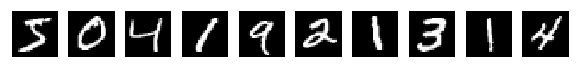

In [3]:
visulize(10, x_train)

# Models

## Bayesian Semi-supervised Autoencoder

We define our Bayesian Semi-supervised Autoencoder as follows: 


$\Sigma_{1e},\Sigma_{1d}, \Sigma, \sigma$ are constants. x is the image data we observe, y is the label.

$W_{1e},W_{1d}, W \sim Gaussian(0, \Sigma_{1e}),Gaussian(0, \Sigma_{1d}), Gaussian(0, \Sigma)$

$z \sim relu(W_{1e}x), \hat{x} \sim relu(W_{1d}x), x \sim Gaussian(\hat{x}, \sigma), y \sim Categorical(Softmax(Wz))$

The graphical model is as follows

![](img/SemiBAE.png)

For detailed notebook, please go to Bayesian_AE.ipynb

Model description goes here.

![](img/Bayesian_AE_model.png)

## Autoencoder

![](img/autoencoder.png)

image from https://www.doc.ic.ac.uk/~js4416/163/website/autoencoders/

# Inference

In this project we only use KLqp as our inference method. As inference is not our main focus in this project, we give a very brief and fast introduction

![](img/Bayesian_AE_inference.png)

# Criticism

In this project we have two types of model criticism: i) image reconstruction ii) classification accuracy. To get some intuition on how to perforom model criticism rigidly in Probabilistic Programming language setting, we first worked on a toy model criticism: studying the relationship between classification accuracy and the extent of matching between parameter prior and posterior in bayesian logistic regression.

## Criticism on a toy example: bayesian logistic regression

In brief, the graphical model of bayesian logistics regression is: $W \sim \Sigma, y \sim Categorical(softmax(Wx))$, where x is the image and y the labels

![](img/BLR.png)

Here are some runs of Bayesian logistic regression on MNIST image. Statistics on: loss over training, accuracy and parameter prior-posterior are collected 

![](img/BLRG.png)

The prior distribution of the parameters does not seem to capture the heavy tail; switch to laplace distribution

![](img/BLRLS.png)

Prior to centered, try flattening it.

![](img/BLRLF.png)

### Through these runs, can we reach the conclusion that: the closer the prior and posterior, the better the accuracy?

Some further results

![](img/BLRComparison.png)

### An important lesson we learned throughout this project: while doing model criticism, always run multiple times to compare the performance, which itself is probablistic

## Criticism on Learned Representation (through visualization)

### Semi-supervised Bayesian Autoencoder

![](img/Bayesian_AE_prior_draw.png)

![](img/Bayesian_AE_posterior_draw.png)

![](img/Bayesian_AE_training_loss.png)

### Autoencoder in Keras

We also build a autoencoder in Keras for comparison purposes. For detailed notebook, please go to AE.ipynb

![](img/AE_reconstruct.png)

## Criticism On Classification Accuracy

We save the encoded representation of both models (semisupervised bayesian autoencoder) and autoencoder, and then use a two layer bayesian neural network to perform classification and test their respective accuracy.

### Classification Algorithm: bayesian deep neural network

In [4]:
# define model here
num_hidden = 100
D = 256
num_class = 10

W_0 = Normal(loc = tf.zeros([D, num_hidden]), scale = tf.ones([D, num_hidden]))
W_1 = Normal(loc = tf.zeros([num_hidden, num_class]), scale = tf.ones([num_hidden,num_class]))
b_0 = Normal(loc = tf.zeros(num_hidden), scale = tf.ones(num_hidden))
b_1 = Normal(loc = tf.zeros(num_class), scale = tf.ones(num_class))

x = tf.placeholder(tf.float32, [None, D])

y = Categorical(logits=NN_classifier(x, W_0, W_1, b_0, b_1))


In [5]:
# define the variational model here
qW_0 = Normal(loc = tf.Variable(tf.random_normal([D,num_hidden])),
                  scale = tf.nn.softplus(tf.Variable(tf.random_normal([D,num_hidden]))))
qW_1 = Normal(loc = tf.Variable(tf.random_normal([num_hidden,num_class])),
                  scale = tf.nn.softplus(tf.Variable(tf.random_normal([num_hidden,num_class]))))
qb_0 = Normal(loc = tf.Variable(tf.random_normal([num_hidden])),
                  scale = tf.nn.softplus(tf.Variable(tf.random_normal([num_hidden]))))
qb_1 = Normal(loc = tf.Variable(tf.random_normal([num_class])),
                   scale = tf.nn.softplus(tf.Variable(tf.random_normal([num_class]))))

## Accuracy Comparison

### Accuracy based on Keras Autoencoder Representation

In [6]:
# inferece initilization for AE representation
inference = ed.KLqp({W_0:qW_0, b_0:qb_0,
                    W_1:qW_1, b_1:qb_1}, 
                    data = {x: x_train_AE, y: y_train})
inference.initialize(n_iter = 1000, n_samples = 5)
tf.global_variables_initializer().run()

In [7]:
# prior draw and prediction accuracy for AE representation
pri_qW_0 = qW_0.sample()
pri_qW_1 = qW_1.sample()
pri_qb_0 = qb_0.sample()
pri_qb_1 = qb_1.sample()

prior_weights = [pri_qW_0, pri_qW_1, pri_qb_0, pri_qb_1] 

print("training accuracy:")
print(accuracy(x_train_AE, y_train, prior_weights))
print("testing accuracy:")
print(accuracy(x_test_AE, y_test, prior_weights))

training accuracy:
0.09811666666666667
testing accuracy:
0.0931


In [ ]:
n_epoch = 100
n_iter_per_epoch = x_train_AE.shape[0] // M
loss = []
for epoch in range(1, n_epoch + 1):
    print("Epoch: {0}".format(epoch))
    avg_loss = 0.0

    # pbar = Progbar(n_iter_per_epoch)
    for t in range(1, n_iter_per_epoch + 1):
        # pbar.update(t)
        x_batch, y_batch = next(x_train_generator_AE)
        info_dict = inference.update(feed_dict={x: x_batch, y: y_batch})
        avg_loss += info_dict['loss']
        avg_loss = avg_loss / n_iter_per_epoch
        avg_loss = avg_loss / M
        loss.append(avg_loss)
    print("-log p(x) <= {:0.3f}".format(avg_loss))

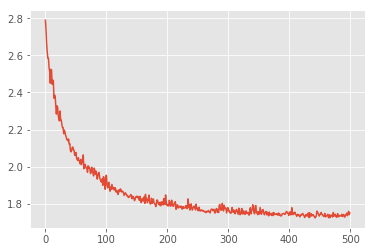

In [9]:
# training loss plot
plt.plot(range(5 * n_epoch), loss)
plt.show()

In [10]:
# posterior accuracy check for AE representation
pos_qW_0 = qW_0.sample()
pos_qW_1 = qW_1.sample()
pos_qb_0 = qb_0.sample()
pos_qb_1 = qb_1.sample()

posterior_weights = [pos_qW_0, pos_qW_1, pos_qb_0, pos_qb_1] 

print("training accuracy:")
print(accuracy(x_train_AE, y_train, prior_weights))
print("testing accuracy:")
print(accuracy(x_test_AE, y_test, prior_weights))

training accuracy:
0.8150666666666667
testing accuracy:
0.8092


### Accuracy based on Semi-supervised Bayesian Autoencoder Representation

In [11]:
# inferece initilization for Bayesian AE representation
inference = ed.KLqp({W_0:qW_0, b_0:qb_0,
                    W_1:qW_1, b_1:qb_1}, 
                    data = {x: x_train_BAE, y: y_train})
inference.initialize(n_iter = 1000, n_samples = 5)
tf.global_variables_initializer().run()

In [12]:
# prior draw and prediction accuracy for Bayesian AE representation
pri_qW_0 = qW_0.sample()
pri_qW_1 = qW_1.sample()
pri_qb_0 = qb_0.sample()
pri_qb_1 = qb_1.sample()

prior_weights = [pri_qW_0, pri_qW_1, pri_qb_0, pri_qb_1] 

print("training accuracy:")
print(accuracy(x_train_BAE, y_train, prior_weights))
print("testing accuracy:")
print(accuracy(x_test_BAE, y_test, prior_weights))


training accuracy:
0.10358333333333333
testing accuracy:
0.0586


In [ ]:
n_epoch = 100
n_iter_per_epoch = x_train_BAE.shape[0] // M
loss = []
for epoch in range(1, n_epoch + 1):
    print("Epoch: {0}".format(epoch))
    avg_loss = 0.0

    # pbar = Progbar(n_iter_per_epoch)
    for t in range(1, n_iter_per_epoch + 1):
        # pbar.update(t)
        x_batch, y_batch = next(x_train_generator_BAE)
        info_dict = inference.update(feed_dict={x: x_batch, y: y_batch})
        avg_loss += info_dict['loss']
        avg_loss = avg_loss / n_iter_per_epoch
        avg_loss = avg_loss / M
        loss.append(avg_loss)
    print("-log p(x) <= {:0.3f}".format(avg_loss))

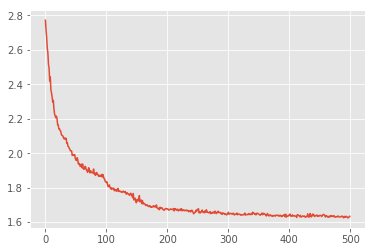

In [14]:
# training loss plot
plt.plot(range(5 * n_epoch), loss)
plt.show()

In [15]:
# posterior accuracy check for Bayesian AE representation
pos_qW_0 = qW_0.sample()
pos_qW_1 = qW_1.sample()
pos_qb_0 = qb_0.sample()
pos_qb_1 = qb_1.sample()

posterior_weights = [pos_qW_0, pos_qW_1, pos_qb_0, pos_qb_1] 

print("training accuracy:")
print(accuracy(x_train_BAE, y_train, prior_weights))
print("testing accuracy:")
print(accuracy(x_test_BAE, y_test, prior_weights))

training accuracy:
0.8981333333333333
testing accuracy:
0.8901


We run the above procedures several times to get a stable comparison. 

![](img/Comparison.png)

### Conclusion: semi supervised bayesian auto encoder outperforms auto encoder in classification problem by a stable and healthy margin. We also observe that the loss in semi-supervised Bayesian auto encoder is smoother than that of auto encoder. However, it still remains unknown whether it is the representation or the probabilistic part that is effective. Due to project time limit, we do not have time to run experiments to investigate this.

# Reference

[1] LeCun, Y., Bottou, L., Bengio, Y., and Haffner, P. (1998). Gradient-based learning applied to document recognition. Proceedings of the IEEE, 86, 2278–2324.
[2]Baldi, P.. (2012). Autoencoders, Unsupervised Learning, and Deep Architectures. Proceedings of ICML Workshop on Unsupervised and Transfer Learning, in PMLR 27:37-49